# Team Name: Runtime Terrors

# Members: Will Graham,  Arushi Gupta, Jayesh Jain

# Neural Networks - Sparse Autoencoders

Imporitng important Libraries.
--

In [9]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

%matplotlib inline

Using TensorFlow backend.


Loading the data
-----------------------

In [11]:
df = pd.read_csv("creditcard.csv")

Preparing the data
-----------------------

In [12]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
data = df.drop(['Time'], axis=1)

Normalising the data
-----------------------

In [13]:
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Splitting the data -<br>
-----------------------
    Training Data = 80%
    Testing Data = 20%

In [14]:
X = data.drop(labels='Class', axis=1)
Y = data.loc[:,'Class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

NN - Training and Building the Autoencoder Model:
--------------------------------

In [6]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)

decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

epoch = 100
batch_size = 32
LABELS = ["Normal", "Fraud"]

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="sparse_autoencoder_model.h5",verbose=0,save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227845 samples, validate on 28481 samples
Epoch 1/100
227845/227845 [==============================] - 21s 92us/step - loss: 0.8638 - accuracy: 0.5648 - val_loss: 0.8297 - val_accuracy: 0.6406
Epoch 2/100
227845/227845 [==============================] - 20s 88us/step - loss: 0.7959 - accuracy: 0.6599 - val_loss: 0.8105 - val_accuracy: 0.6712
Epoch 3/100
227845/227845 [==============================] - 20s 88us/step - loss: 0.7861 - accuracy: 0.6711 - val_loss: 0.8059 - val_accuracy: 0.6750
Epoch 4/100
227845/227845 [==============================] - 20s 89us/step - loss: 0.7824 - accuracy: 0.6753 - val_loss: 0.8022 - val_accuracy: 0.6732
Epoch 5/100
227845/227845 [==============================] - 21s 91us/step - loss: 0.7802 - accuracy: 0.6771 - val_loss: 0.7982 - val_accuracy: 0.6793
Epoch 6/100
227845/227845 [==============================] - 21s 91us/step - loss: 0.7782 - accuracy: 0.6773 - val_loss: 0.7966 - val_accuracy: 0.6805
Epoch 7/100
227845/227845 [================

NN - Visualing accuracy results from the autoencoder:
--------------------

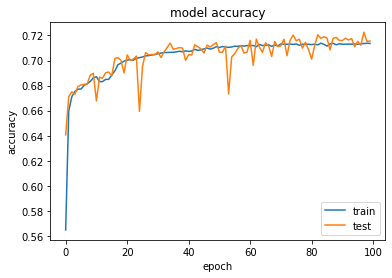

In [7]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right');

NN - Visualing loss results from the autoencoder:
--------------------

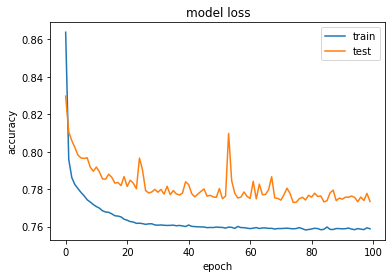

In [8]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

NN - Calculating MSE for decision making
---------------------------------------------------

In [15]:
predictions = load_model("sparse_autoencoder_model.h5").predict(X_test)
mean_sq_error = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mean_sq_error,'true_class': Y_test})

NN - Deciding the Threshold for decision making:
---------------------------------------------------

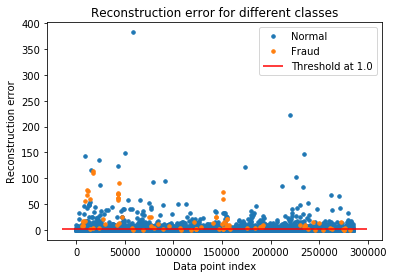

Penalty for this threshold: -6856


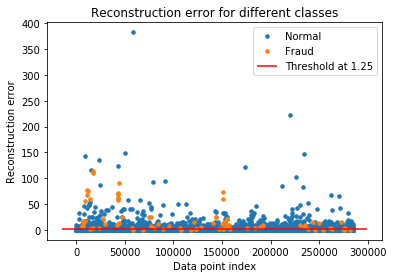

Penalty for this threshold: -5386


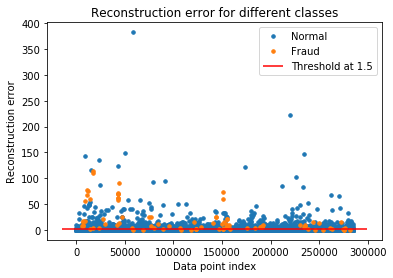

Penalty for this threshold: -4905


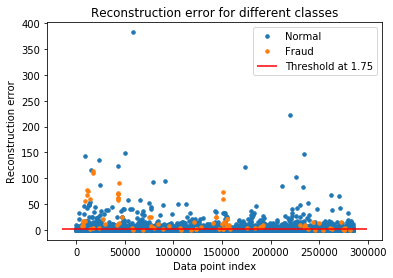

Penalty for this threshold: -4380


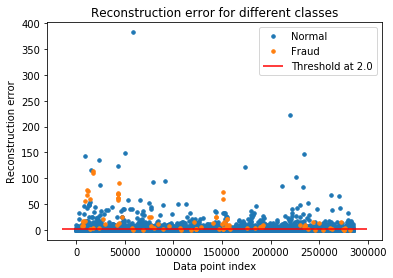

Penalty for this threshold: -4023


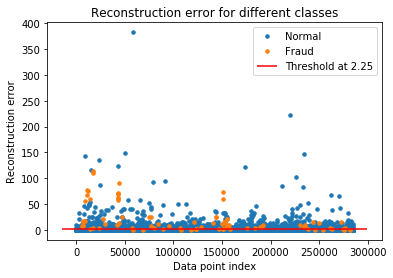

Penalty for this threshold: -3865


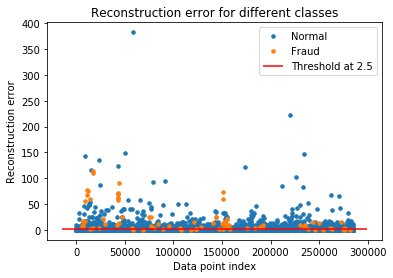

Penalty for this threshold: -3673


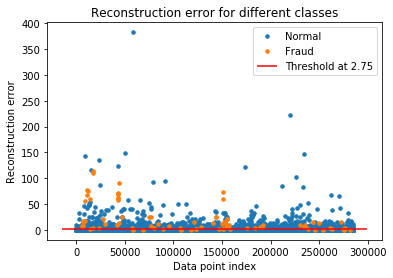

Penalty for this threshold: -3511


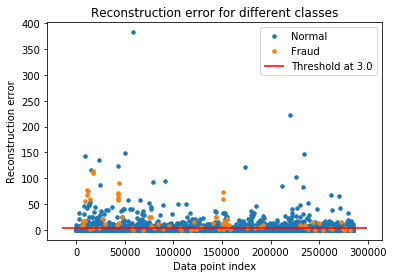

Penalty for this threshold: -3387


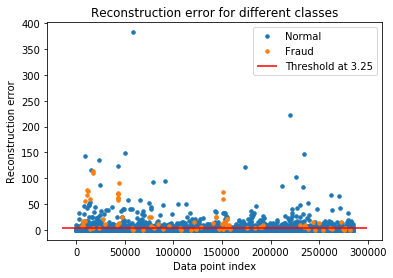

Penalty for this threshold: -3397


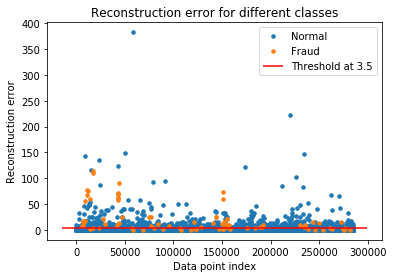

Penalty for this threshold: -3308


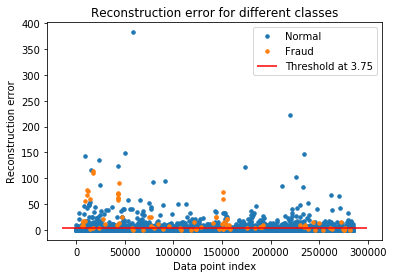

Penalty for this threshold: -3516


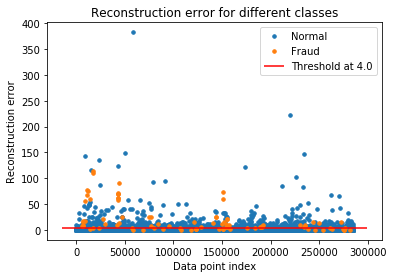

Penalty for this threshold: -3728


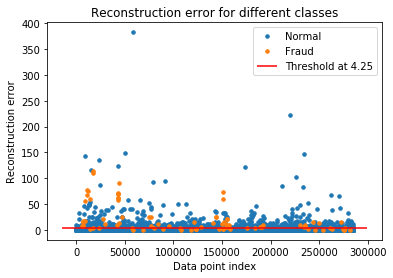

Penalty for this threshold: -3769


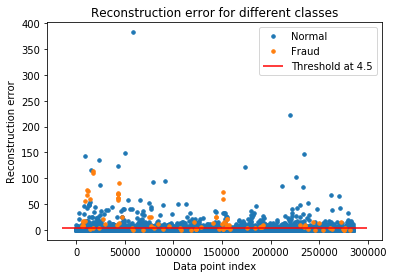

Penalty for this threshold: -3721


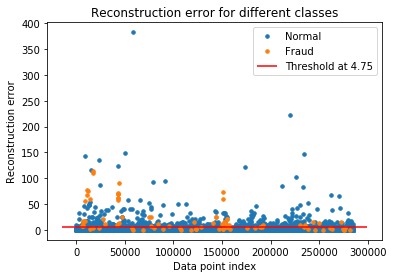

Penalty for this threshold: -3765


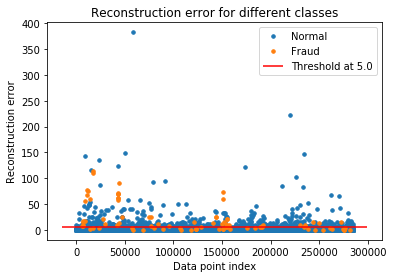

Penalty for this threshold: -3931


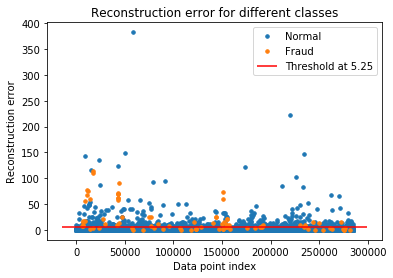

Penalty for this threshold: -3905


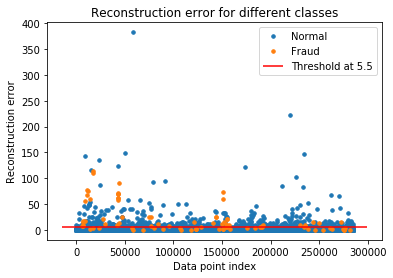

Penalty for this threshold: -4072


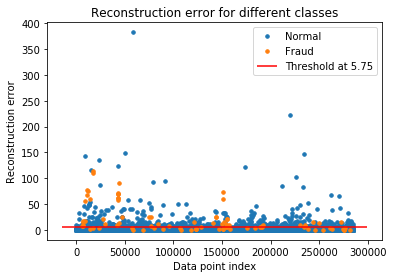

Penalty for this threshold: -4233


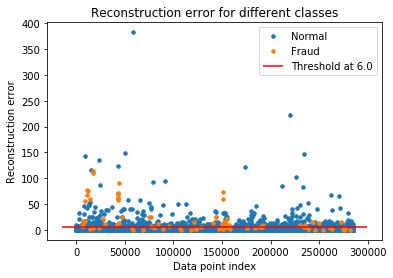

Penalty for this threshold: -4304


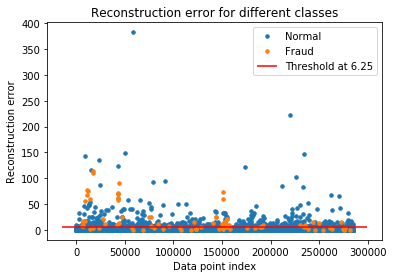

Penalty for this threshold: -4266


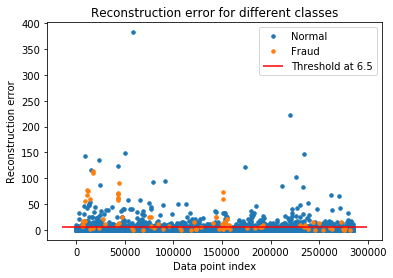

Penalty for this threshold: -4229


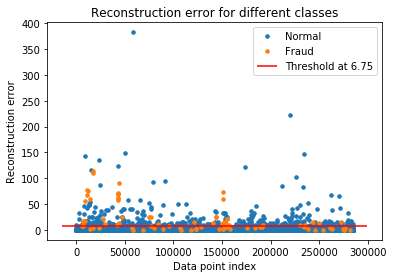

Penalty for this threshold: -4208


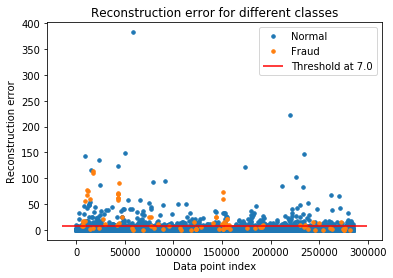

Penalty for this threshold: -4179


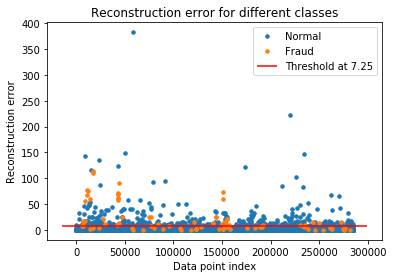

Penalty for this threshold: -4258


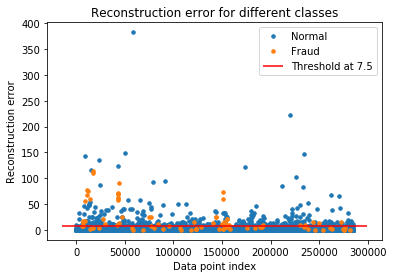

Penalty for this threshold: -4332


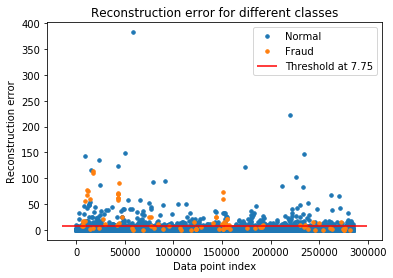

Penalty for this threshold: -4412


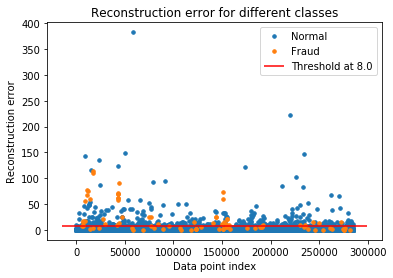

Penalty for this threshold: -4387


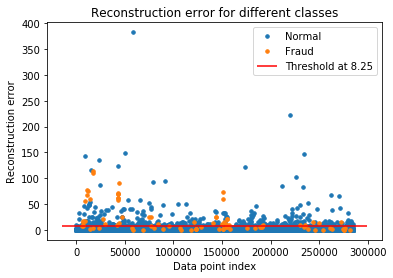

Penalty for this threshold: -4475


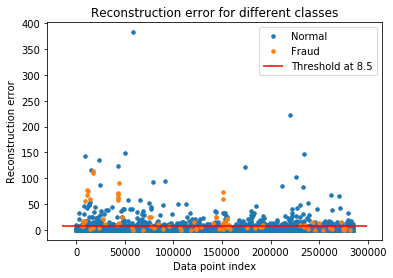

Penalty for this threshold: -4661


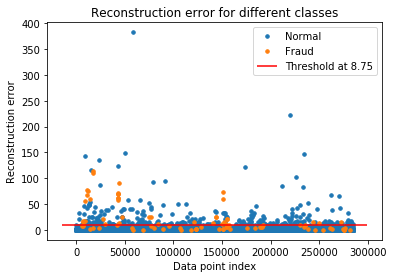

Penalty for this threshold: -4745


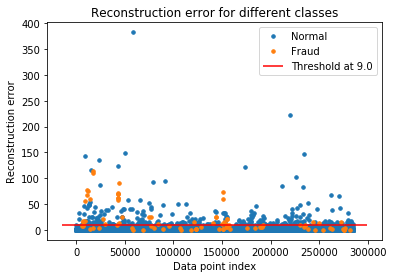

Penalty for this threshold: -4831


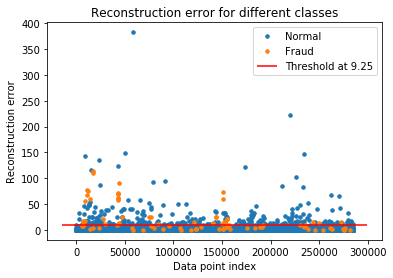

Penalty for this threshold: -4921


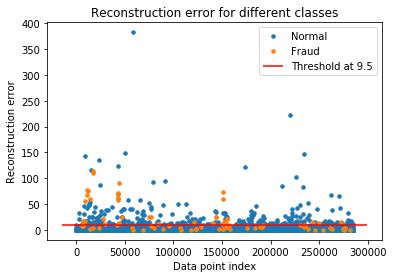

Penalty for this threshold: -5009


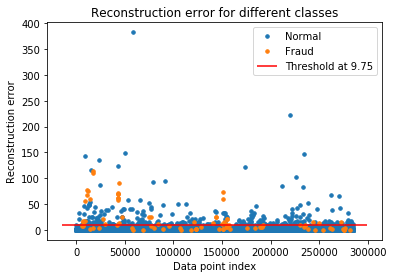

Penalty for this threshold: -4999

The best threshold that optimises the number of false negatives and false positives is: 3.5
At this threshold, the penalty is lowest at -3308


In [22]:
threshold_list = np.arange(1,10,0.25)
groups = error_df.groupby('true_class')
fp = {}
penalty = {}

for t in range(len(threshold_list)):
    threshold = threshold_list[t]
    # plotting the graph
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',label= "Fraud" if name == 1 else "Normal")
    l = "Threshold at " + str(threshold)
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label=l)
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show();
    
    # making predictions based on the current threshold to see which of those is better
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)
    fp[threshold] = conf_matrix[1][0]
    fp_t = conf_matrix[1][0]
    fn_t = conf_matrix[0][1]
    penalty_t = (fn_t*(-1)) + (fp_t*(-100))
    penalty[threshold] = penalty_t
    print("Penalty for this threshold:", penalty_t)

penalty_final = (max(list(penalty.values())))
threshold_final = threshold_list[list(penalty.values()).index((max(list(penalty.values()))))]
print()
print("The best threshold that optimises the number of false negatives and false positives is:", threshold_final)
print("At this threshold, the penalty is lowest at", penalty_final)

NN - Predicting values:
--------------------------------

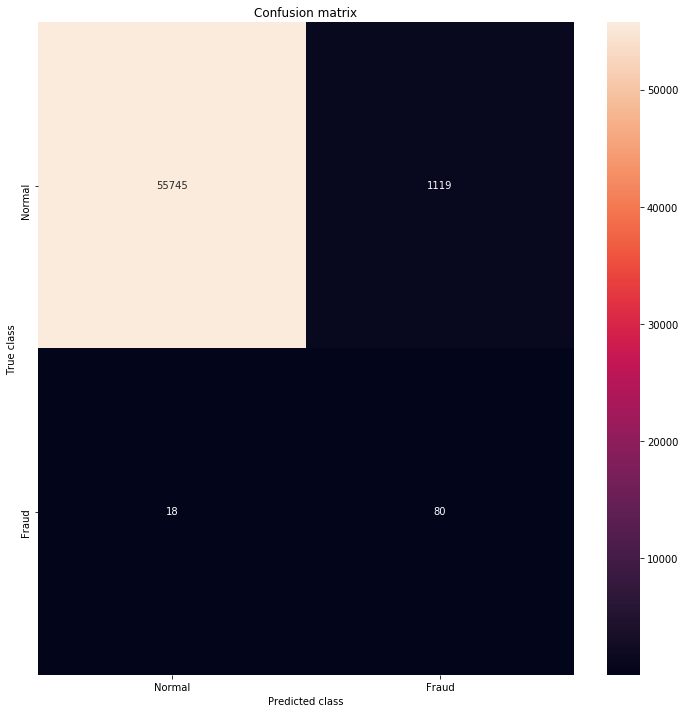

Accuracy of the model: 98.6 %


In [20]:
conf_matrix = np.array([[55745,1119],[18,80]])

LABELS = ['Normal', 'Fraud']
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

sc = np.round(sklearn.metrics.accuracy_score(error_df.true_class, y_pred, normalize=True, sample_weight=None),4)

print("Accuracy of the model:", sc*100,"%")

NN - Results and Report
--------

In [21]:
fp = conf_matrix[1][0]
fn = conf_matrix[0][1]
tp = conf_matrix[0][0]
tn = conf_matrix[1][1]
print("Total datapoints:", fp+tp+tn+fn)
print("----------------------------")
print("No. of False-Positives", fp)
print("No. of True-Positives", tp)
print("No. of False-Negatives", fn)
print("No. of True-Negatives", tn)
print("----------------------------")
print("Correctly predicted:", tn+tp)
print("Incorrectly predicted:", fn+fp)
print("----------------------------")
print("We see that the NN model is", sc*100, "% accurate.\n")
print("This is misleading and can be considered a drawback of heavily imbalanced datasets.\n") 
print("In the testing dataset, we have only", sum(conf_matrix[1]), "cases of fraud transactions and we identify",
      fp, "of them as normal transactions using our algorithm, which produces an error rate of",
      np.round(fp/sum(conf_matrix[1]),4)*100, "% \n")
print("We correctly predict the normal transactions at an accuracy% of",
      np.round(tp/sum(conf_matrix[0]),4)*100, "%.\n")
print("This overtakes the accuracy rate of fraud transactions:",
      np.round(tn/sum(conf_matrix[1]),4)*100, "% we have for detecting fraud transactions and thus gives",
      "us the final accuracy of approximately", sc*100,"%")

Total datapoints: 56962
----------------------------
No. of False-Positives 18
No. of True-Positives 55745
No. of False-Negatives 1119
No. of True-Negatives 80
----------------------------
Correctly predicted: 55825
Incorrectly predicted: 1137
----------------------------
We see that the NN model is 98.6 % accurate.

This is misleading and can be considered a drawback of heavily imbalanced datasets.

In the testing dataset, we have only 98 cases of fraud transactions and we identify 18 of them as normal transactions using our algorithm, which produces an error rate of 18.37 % 

We correctly predict the normal transactions at an accuracy% of 98.03 %.

This overtakes the accuracy rate of fraud transactions: 81.63 % we have for detecting fraud transactions and thus gives us the final accuracy of approximately 98.6 %
